In [98]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import fuzzy as fy
from collections import namedtuple
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import brute

In [9]:
nat = pd.read_csv('NationalNames.csv')

In [52]:
samp = nat.sample(100000)

In [53]:
soundex = fy.Soundex(4)

In [54]:
samp['Soundex'] = samp.Name.apply(soundex)
samp['nyiis'] = samp.Name.apply(fy.nysiis)
samp['new_name'] = samp.Name.str.lower()
# samp = samp.set_index(['new_name', 'Year'])

In [55]:
samp['sound_strip'] = samp.Soundex.map(lambda x: x.strip('0'))
samp['first_syl'] = samp.sound_strip.str[0]
samp['last_syl'] = samp.sound_strip.str[-1]

In [56]:
samp.head()

,Id,Name,Year,Gender,Count,Soundex,nyiis,new_name,sound_strip,first_syl,last_syl
621487,621488,FAYE,1964,F,439,F000,FY,faye,F,F,F
322100,322101,OMA,1935,F,109,O500,ON,oma,O5,O,5
1342856,1342857,KELLER,2000,F,9,K460,CALAR,keller,K46,K,6
659259,659260,ISABELla,1967,F,44,I214,ISABAL,isabella,I214,I,4
977237,977238,LIZANDro,1985,M,13,L253,LASANDR,lizandro,L253,L,3


In [57]:
first_series = samp.groupby(['Year','first_syl']).Count.sum()

In [58]:
A_ser = first_series.loc[(first_series.index.get_level_values('first_syl')=='A')]

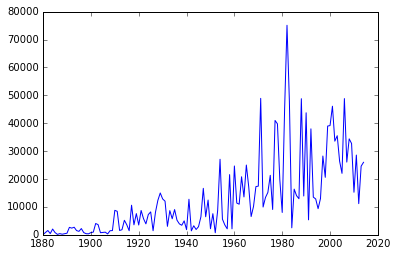

In [59]:
plt.plot(A_ser.index.get_level_values('Year'), A_ser.values)

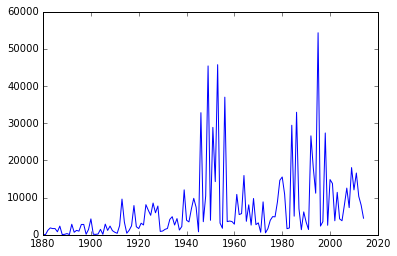

In [60]:
B_ser = first_series.loc[(first_series.index.get_level_values('first_syl')=='B')]
plt.plot(B_ser.index.get_level_values('Year'), B_ser.values)

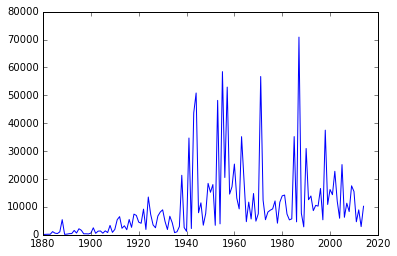

In [61]:
C_ser = first_series.loc[(first_series.index.get_level_values('first_syl')=='C')]
plt.plot(C_ser.index.get_level_values('Year'), C_ser.values)

In [62]:
totals = samp.groupby(['Year']).Count.sum()

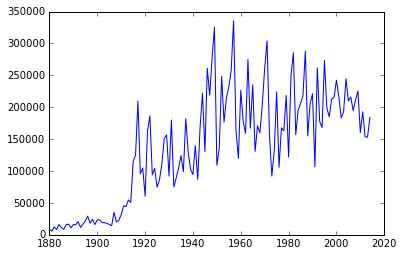

In [63]:
plt.plot(totals.index, totals.values)

In [70]:
A = A_ser/totals
B = B_ser/totals
C = C_ser/totals

In [71]:
A.describe(), B.describe(), C.describe()

(count    135.000000
 mean       0.088865
 std        0.067859
 min        0.002980
 25%        0.037828
 50%        0.072182
 75%        0.126819
 max        0.314465
 Name: Count, dtype: float64, count    135.000000
 mean       0.056090
 std        0.053931
 min        0.002239
 25%        0.014425
 50%        0.037712
 75%        0.079720
 max        0.258755
 Name: Count, dtype: float64, count    135.000000
 mean       0.071704
 std        0.061610
 min        0.006239
 25%        0.025855
 50%        0.055137
 75%        0.094701
 max        0.325753
 Name: Count, dtype: float64)

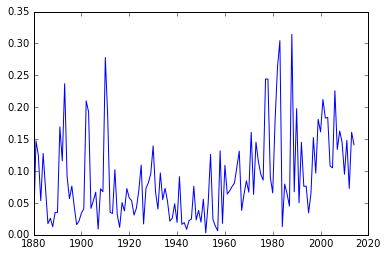

In [77]:
plt.plot(totals.index, A.values)

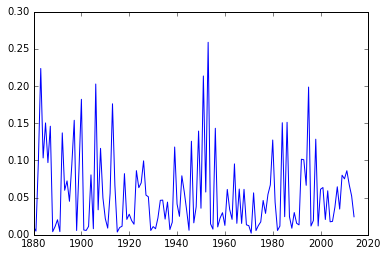

In [78]:
plt.plot(totals.index, B.values)

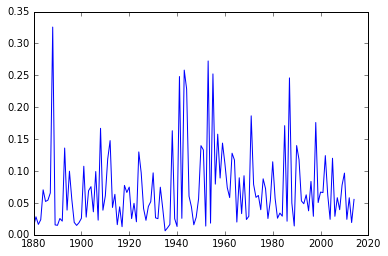

In [79]:
plt.plot(totals.index, C.values)

In [87]:
C_model = sm.OLS(C_ser.values, sm.add_constant(totals.index)).fit()

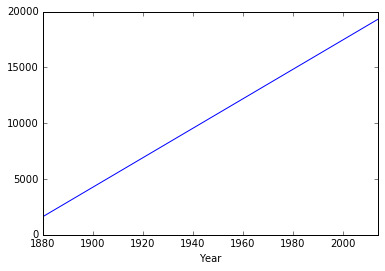

In [88]:
pd.Series(C_model.fittedvalues, index=totals.index).plot()

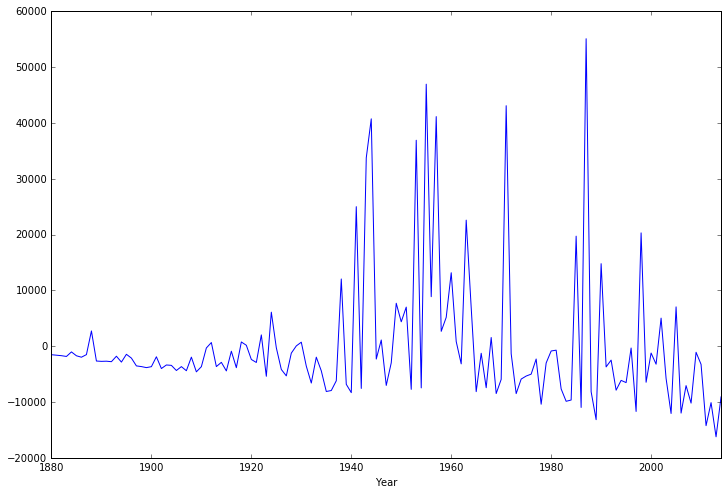

In [92]:
detrend = pd.Series(C_model.resid, index=totals.index)
detrend.plot(figsize=(12,8))

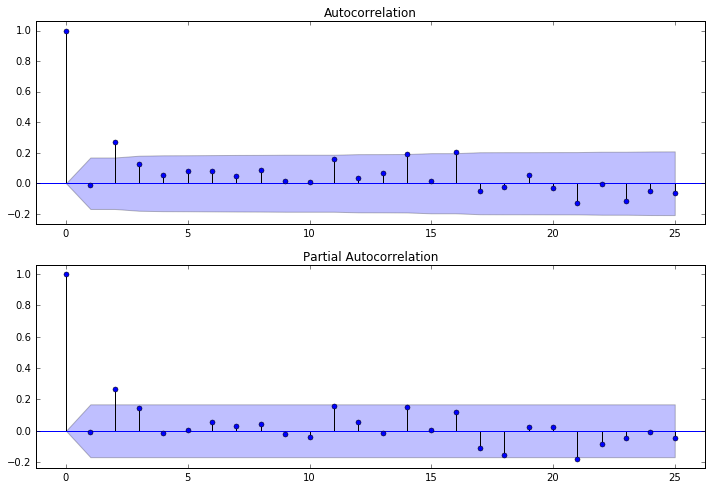

In [97]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(detrend, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(detrend, lags=25, ax=ax2)

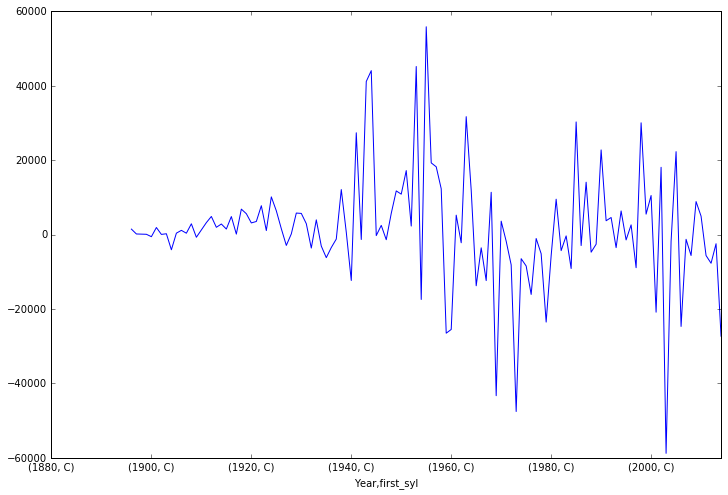

In [107]:
C_diff = C_ser.diff(periods=16)
C_diff.plot(figsize=(12,8))

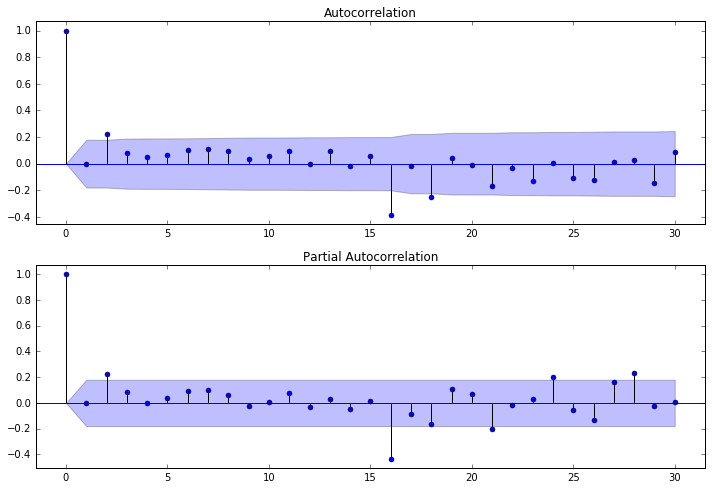

In [108]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(C_diff[16:], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(C_diff[16:], lags=30, ax=ax2)

In [145]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

In [128]:
time = totals.index.tolist()

In [146]:
def objfunc(order, exog, endog):
    fit = ARIMA(endog, order, exog).fit()
    return fit.aic()

grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
# brute(objfunc, grid, args=(C_ser.values, time), finish=None)

In [168]:
#Pass a function all the possible parameters for ARIMA and determine the lowest AIC's parameters;


(slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))

In [156]:
arma_order_select_ic(C_ser, ic=['aic','bic'], trend='nc')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [150]:
from statsmodels.tsa.arima_process import arma_generate_sample
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
arparams = np.r_[1, -arparams]
maparam = np.r_[1, maparams]
nobs = 250
np.random.seed(2014)
y = arma_generate_sample(arparams, maparams, nobs)
res = sm.tsa.arma_order_select_ic(y, ic=['aic', 'bic'], trend='nc')
res.aic_min_order
res.bic_min_order

(1, 2)

In [157]:
mdata = sm.datasets.macrodata.load_pandas().data

In [158]:
mdata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [159]:
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)

In [161]:
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

In [165]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [166]:
var_model = VAR(data)

In [167]:
results = var_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Jun, 2016
Time:                     10:37:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.174
L1.realgdp         -0.279435         0.169663           -1.647           0.101
L1.realcons         0.675016         0.131285            5.142    